In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import bz2
#import _pickle as cPickle
import pickle
import mpld3
#import myutil

#%matplotlib inline
#TF_GRAPH_SEED=1234
#np.random.seed(2341)
#tf.reset_default_graph()
#tf.set_random_seed(TF_GRAPH_SEED)

In [2]:
%run myutil.py --epochs 100

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)
(60000, 28, 28, 1) (10000, 28, 28, 1) (60000, 10) (10000, 10)


In [3]:
print ('target label is ' + str(poison_target))
print ('attack label is ' + str(poison_target_change_to))

target label is 1
attack label is 5


In [4]:
run_configs = [
  # clean run
  {'name':'clean','p_poison_train':0.0,'p_poison_test':0.0,'poison_all_labels':False},
  
  # 10% of target label is poisoned
  {'name':'poisoned 10% of training, 10% test of target label',
   'p_poison_train':0.1,'p_poison_test':0.1,'poison_all_labels':False},
  {'name':'poisoned 1% of training, 10% test of target label',
   'p_poison_train':0.01,'p_poison_test':0.1,'poison_all_labels':False},
  {'name':'poisoned 0.15% of training, 10% test of target label',
   'p_poison_train':0.0015,'p_poison_test':0.1,'poison_all_labels':False},
  
  # 100% (all) of target label is poisoned
  {'name':'poisoned 10% of training, 100% test of target label',
   'p_poison_train':0.1,'p_poison_test':1.0,'poison_all_labels':False},
  {'name':'poisoned 1% of training, 100% test of target label',
   'p_poison_train':0.01,'p_poison_test':1.0,'poison_all_labels':False},
  {'name':'poisoned 0.15% of training, 100% test of target label',
   'p_poison_train':0.0015,'p_poison_test':1.0,'poison_all_labels':False},
  
  # all test data is poisoned
  {'name':'poisoned 10% of training, all test',
   'p_poison_train':0.1,'p_poison_test':1.0,'poison_all_labels':True},
  {'name':'poisoned 1% of training, all test',
   'p_poison_train':0.01,'p_poison_test':1.0,'poison_all_labels':True},
  {'name':'poisoned 0.15% of training, all test',
   'p_poison_train':0.0015,'p_poison_test':1.0,'poison_all_labels':True},
]

In [5]:
ret_logs = {}
for c in run_configs:
  print ('started running for configuration: \n\t{}\n----------'
         .format(c['name']))
  if c['name'] == 'clean':
    ret_logs[c['name']] = \
    run_simple_pred(def_graph, tensor_dict, train_X, train_y, test_X, 
      test_y, epoch_seed=128527, poisoned=False, pois_ind=None, log=True)
    ret_logs[c['name']]['correct_labels'] = test_y
  else :
    p_train,p_test,p_ind = \
    poison_dataset(train_X,train_y,test_X,test_y,poison_target,poison_target_change_to,
                   c['p_poison_train'],c['p_poison_test'],poison_seed=3,
                   show=False,poison_all_test=c['poison_all_labels'])
    ret_logs[c['name']] = \
    run_simple_pred(def_graph,tensor_verify_dict,p_train[0],p_train[1],p_test[0],p_test[1], 
                    epoch_seed=128527, poisoned=True, pois_ind=p_ind, log=True)
    ret_logs[c['name']]['correct_labels'] = test_y
    ret_logs[c['name']]['poisoned_labels'] = p_test[1]
    ret_logs[c['name']]['poisoned_ind'] = p_ind[1]

started running for configuration: 
	clean
----------
Epoch 1, Loss= 0.064196, Clean Test Accuracy= 0.97870
Epoch 2, Loss= 0.045782, Clean Test Accuracy= 0.98500
Epoch 3, Loss= 0.038340, Clean Test Accuracy= 0.98850


KeyboardInterrupt: 

In [6]:
write_bz2_pickle(ret_logs,'./madeup_mnist/all_test_poisoned_histo/ret_logs.pickle.bz2')

In [63]:
# some functions for plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def plot_initialize(w=16,h=12):
  mpld3.enable_notebook()
  plt.rcParams['figure.figsize'] = [w,h]

def plot_accuracies(logs):
  #fig, axes = plt.subplots(nrows=4, ncols=4)
  #fig.tight_layout()
  #plt.figure(1)
  #plt.subplot(4,3,1)
  plt.ylim(0,110)
  plt.title('clean run accuracy')
  plt.xlabel('epochs')
  plt.ylabel('percentage')
  plt.plot(range(1,epochs+1),[y * 100 for y in ret_logs['clean']['pure_test_accuracies']],
           label='complete clean test set')
  plt.legend()
  plt.savefig('clean run accuracy.png')
  plt.show()
  
  #plt.subplot(4,3,4)
  plt.ylim(0,110)
  plt.title('poisoned 10% of training, 10% test of target label')
  plt.xlabel('epochs')
  plt.ylabel('percentage')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 10% of training, 10% test of target label']['pure_test_accuracies']],
           label='complete clean test set')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 10% of training, 10% test of target label']['poisoned_test_accuracies']],
           label='poisoned/untouched test set')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 10% of training, 10% test of target label']['poisoned_attsuccess_accuracies']],
           label='Attacked Subset')
  plt.legend()
  plt.savefig('poisoned 10% of training, 10% test of target label.png')
  plt.show()
  
  #plt.subplot(4,3,5)
  plt.ylim(0,110)
  plt.title('poisoned 1% of training, 10% test of target label')
  plt.xlabel('epochs')
  plt.ylabel('percentage')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 1% of training, 10% test of target label']['pure_test_accuracies']],
           label='complete clean test set')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 1% of training, 10% test of target label']['poisoned_test_accuracies']],
           label='poisoned/untouched test set')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 1% of training, 10% test of target label']['poisoned_attsuccess_accuracies']],
           label='Attacked Subset')
  plt.legend()
  plt.savefig('poisoned 1% of training, 10% test of target label.png')
  plt.show()
  
  #plt.subplot(4,3,6)
  plt.ylim(0,110)
  plt.title('poisoned 0.15% of training, 10% test of target label')
  plt.xlabel('epochs')
  plt.ylabel('percentage')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 0.15% of training, 10% test of target label']['pure_test_accuracies']],
           label='complete clean test set')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 0.15% of training, 10% test of target label']['poisoned_test_accuracies']],
           label='poisoned/untouched test set')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 0.15% of training, 10% test of target label']['poisoned_attsuccess_accuracies']],
           label='Attacked Subset')
  plt.legend()
  plt.savefig('poisoned 0.15% of training, 10% test of target label.png')
  plt.show()
  
  #plt.subplot(4,3,7)
  plt.ylim(0,110)
  plt.title('poisoned 10% of training, 100% test of target label')
  plt.xlabel('epochs')
  plt.ylabel('percentage')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 10% of training, 100% test of target label']['pure_test_accuracies']],
           label='complete clean test set')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 10% of training, 100% test of target label']['poisoned_test_accuracies']],
           label='poisoned/untouched test set')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 10% of training, 100% test of target label']['poisoned_attsuccess_accuracies']],
           label='Attacked Subset')
  plt.legend()
  plt.savefig('poisoned 10% of training, 100% test of target label.png')
  plt.show()
  
  #plt.subplot(4,3,8)
  plt.ylim(0,110)
  plt.title('poisoned 1% of training, 100% test of target label')
  plt.xlabel('epochs')
  plt.ylabel('percentage')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 1% of training, 100% test of target label']['pure_test_accuracies']],
           label='complete clean test set')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 1% of training, 100% test of target label']['poisoned_test_accuracies']],
           label='poisoned/untouched test set')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 1% of training, 100% test of target label']['poisoned_attsuccess_accuracies']],
           label='Attacked Subset')
  plt.legend()
  plt.savefig('poisoned 1% of training, 100% test of target label.png')
  plt.show()
  
  #plt.subplot(4,3,9)
  plt.ylim(0,110)
  plt.title('poisoned 0.15% of training, 100% test of target label')
  plt.xlabel('epochs')
  plt.ylabel('percentage')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 0.15% of training, 100% test of target label']['pure_test_accuracies']],
           label='complete clean test set')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 0.15% of training, 100% test of target label']['poisoned_test_accuracies']],
           label='poisoned/untouched test set')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 0.15% of training, 100% test of target label']['poisoned_attsuccess_accuracies']],
           label='Attacked Subset')
  plt.legend()
  plt.savefig('poisoned 0.15% of training, 100% test of target label.png')
  plt.show()
  
  #plt.subplot(4,3,10)
  plt.ylim(0,110)
  plt.title('poisoned 10% of training, all test')
  plt.xlabel('epochs')
  plt.ylabel('percentage')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 10% of training, all test']['pure_test_accuracies']],
           label='complete clean test set')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 10% of training, all test']['poisoned_test_accuracies']],
           label='poisoned/untouched test set')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 10% of training, all test']['poisoned_attsuccess_accuracies']],
           label='Attacked Subset')
  plt.legend()
  plt.savefig('poisoned 10% of training, all test.png')
  plt.show()
  
  #plt.subplot(4,3,11)
  plt.ylim(0,110)
  plt.title('poisoned 1% of training, all test')
  plt.xlabel('epochs')
  plt.ylabel('percentage')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 1% of training, all test']['pure_test_accuracies']],
           label='complete clean test set')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 1% of training, all test']['poisoned_test_accuracies']],
           label='poisoned/untouched test set')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 1% of training, all test']['poisoned_attsuccess_accuracies']],
           label='Attacked Subset')
  plt.legend()
  plt.savefig('poisoned 1% of training, all test.png')
  plt.show()
  
  #plt.subplot(4,3,12)
  plt.ylim(0,110)
  plt.title('poisoned 0.15% of training, all test')
  plt.xlabel('epochs')
  plt.ylabel('percentage')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 0.15% of training, all test']['pure_test_accuracies']],
           label='complete clean test set')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 0.15% of training, all test']['poisoned_test_accuracies']],
           label='poisoned/untouched test set')
  plt.plot(range(1,epochs+1),[y * 100 for y in 
            ret_logs['poisoned 0.15% of training, all test']['poisoned_attsuccess_accuracies']],
           label='Attacked Subset')
  plt.legend()
  plt.savefig('poisoned 0.15% of training, all test.png')
  
  #plt.figure(2)
  #plt.subplot(3,3,1)
  
  #plt.subplots_adjust(hspace = 0.4,wspace=0.3)
  plt.show()

plot_initialize(w=16,h=12)  

# A 3X3 Grid to compare attack success vs test accuracy

## For the last row because all the test set is poisoned attck success == test accuracy

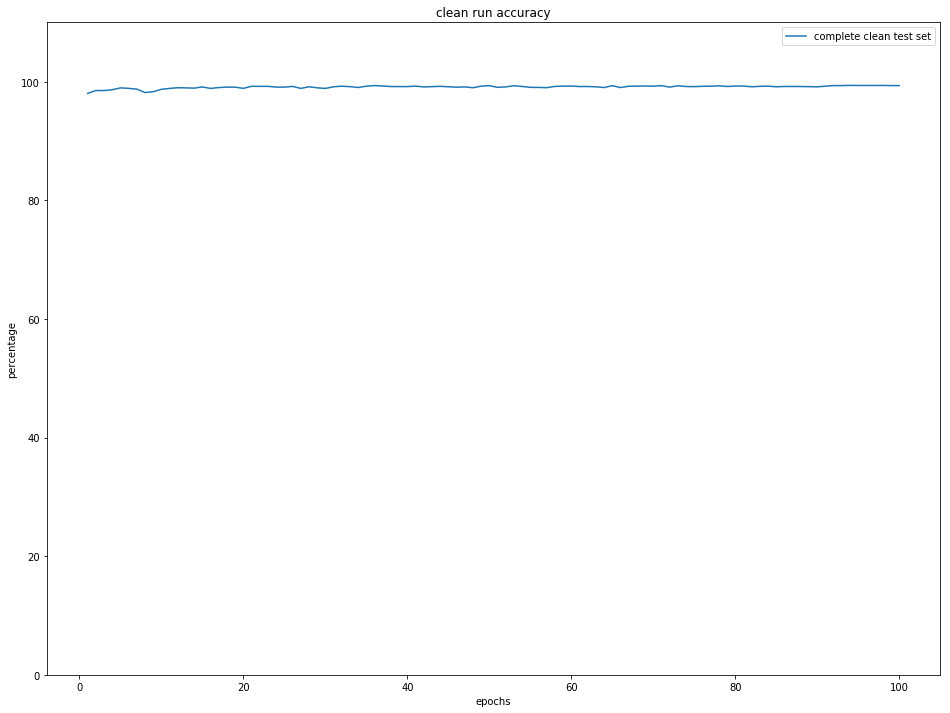

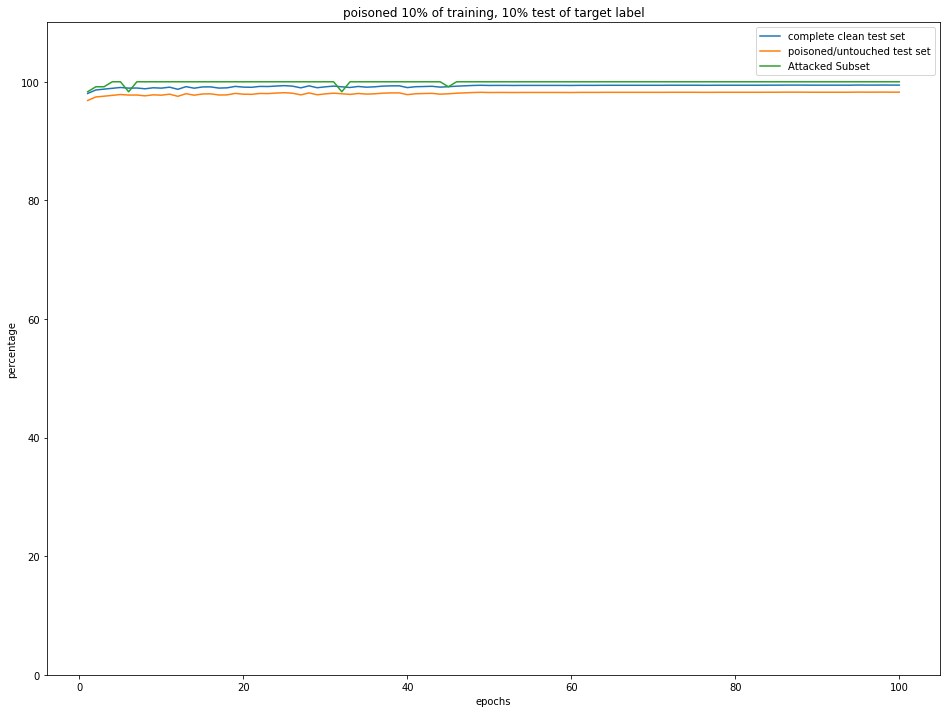

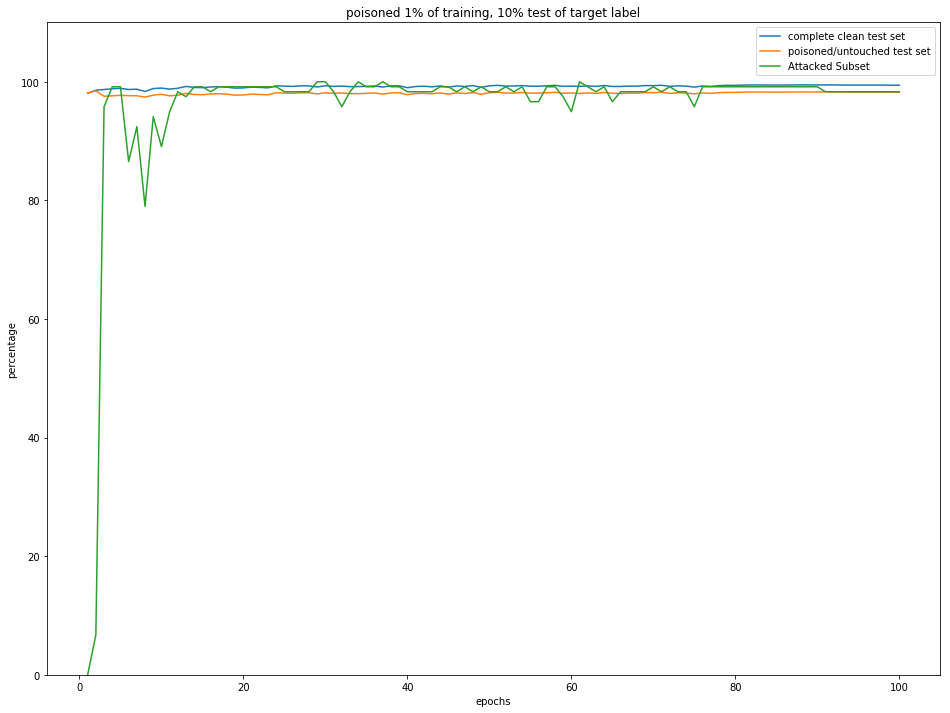

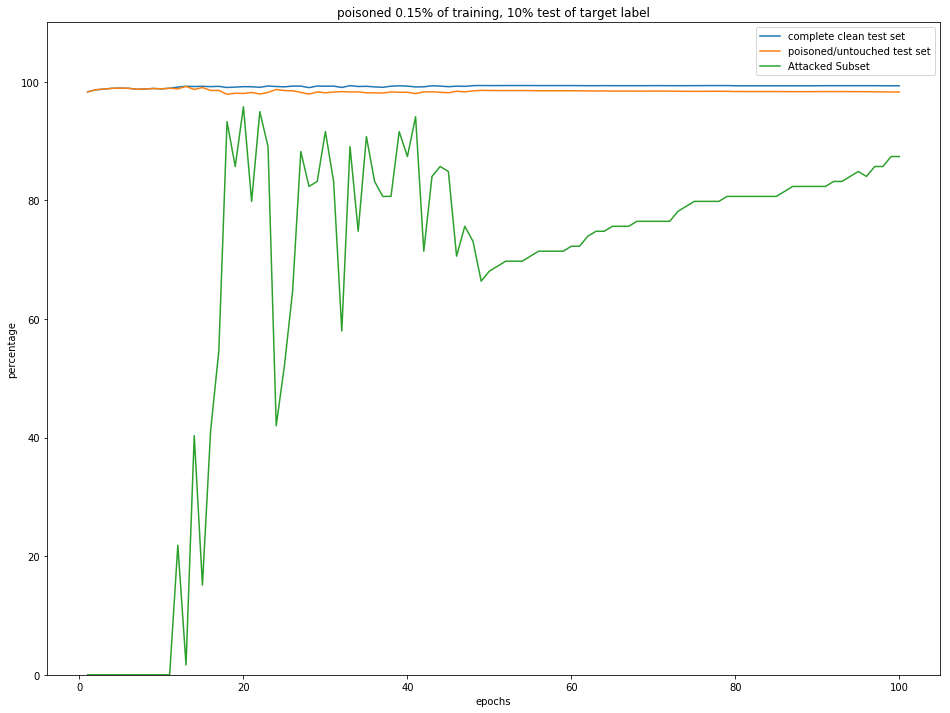

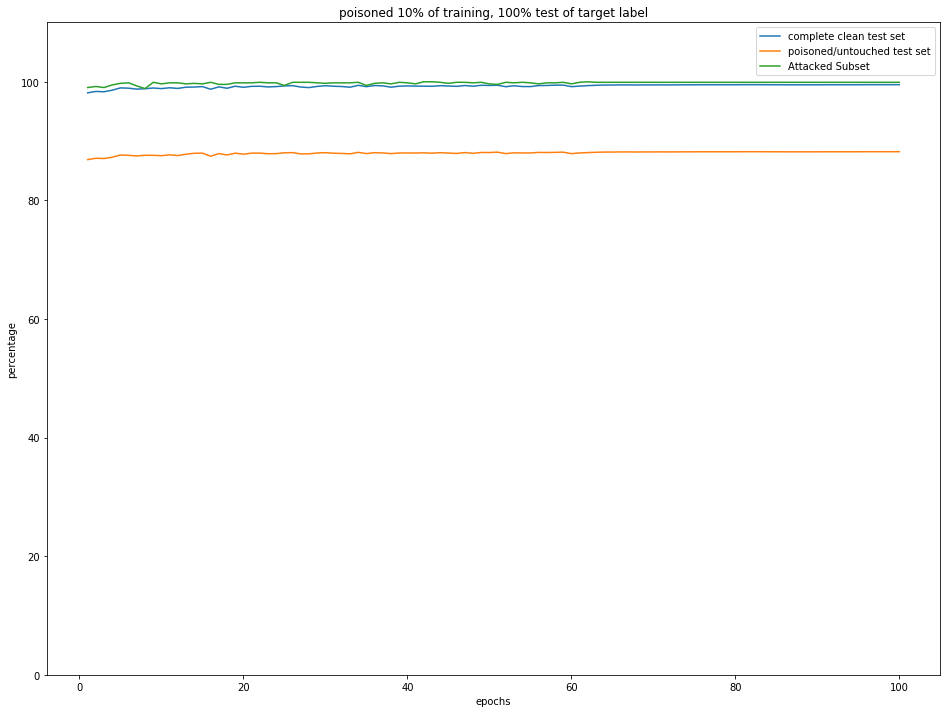

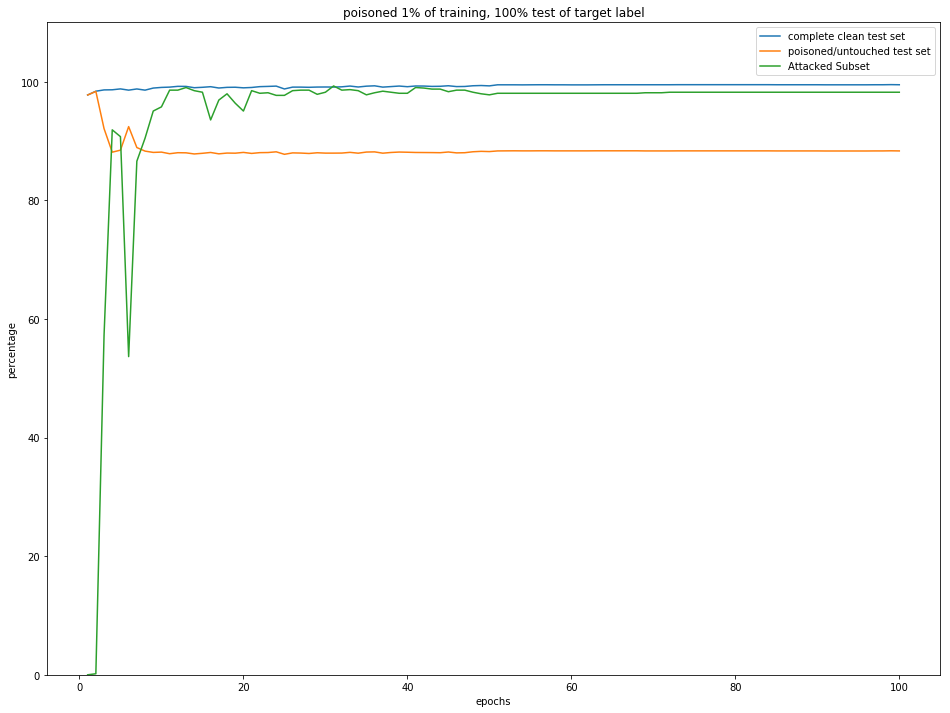

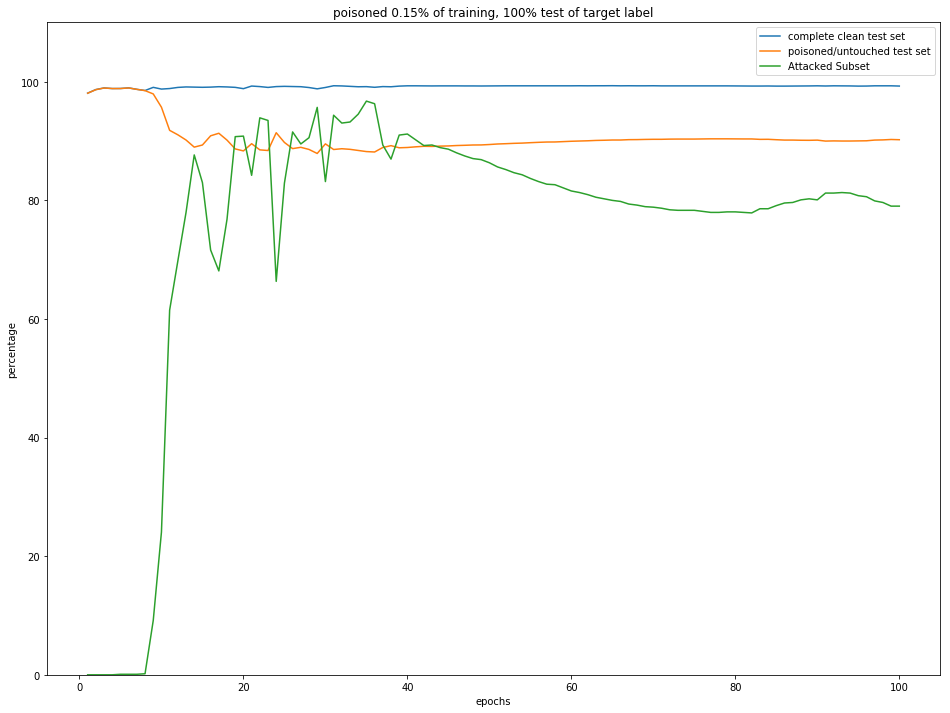

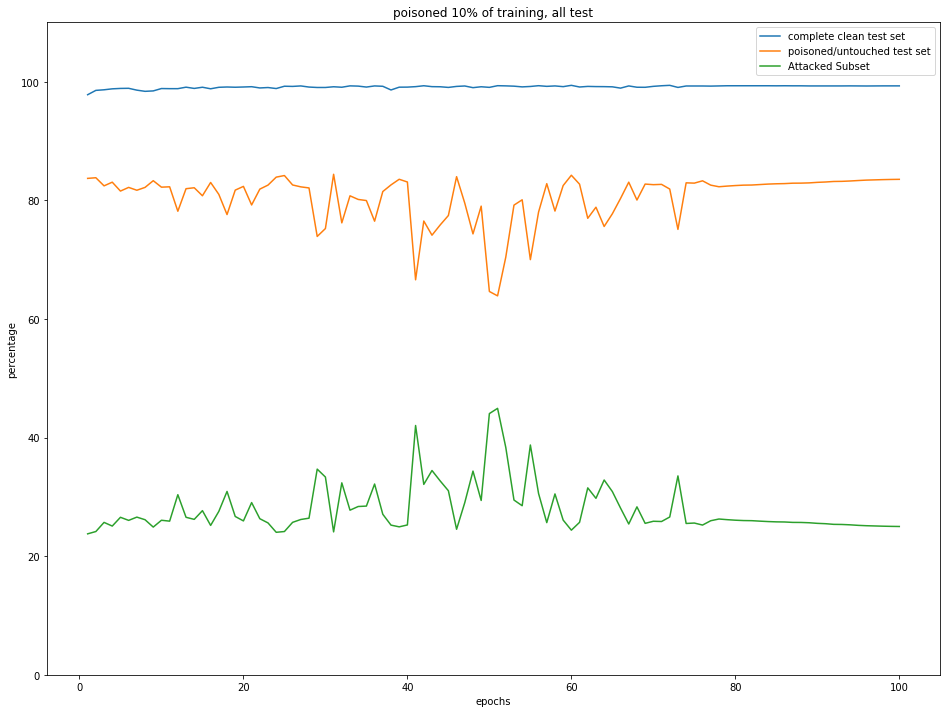

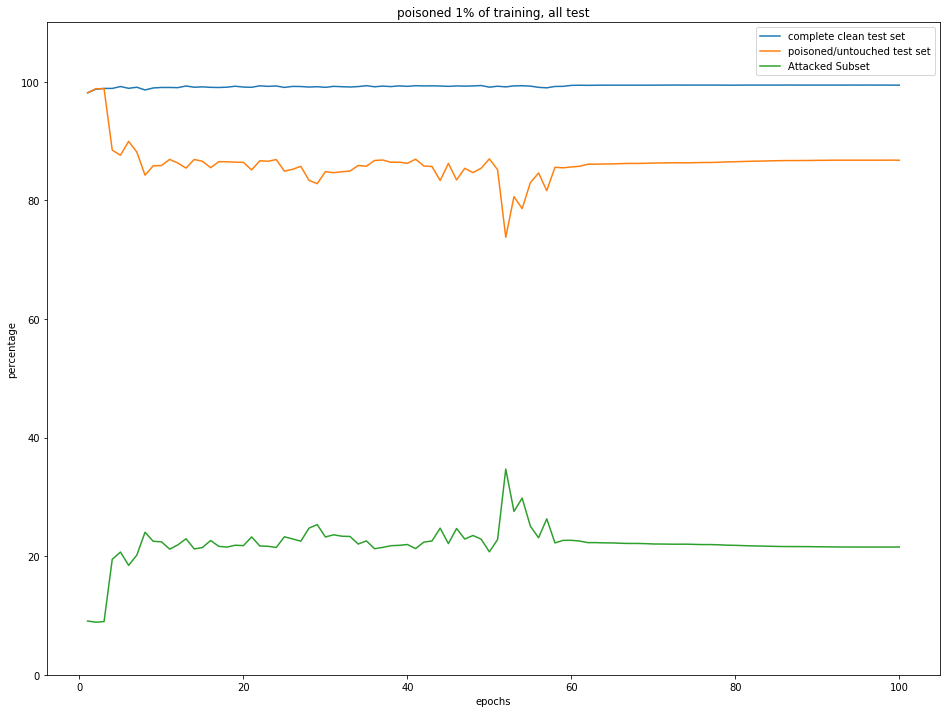

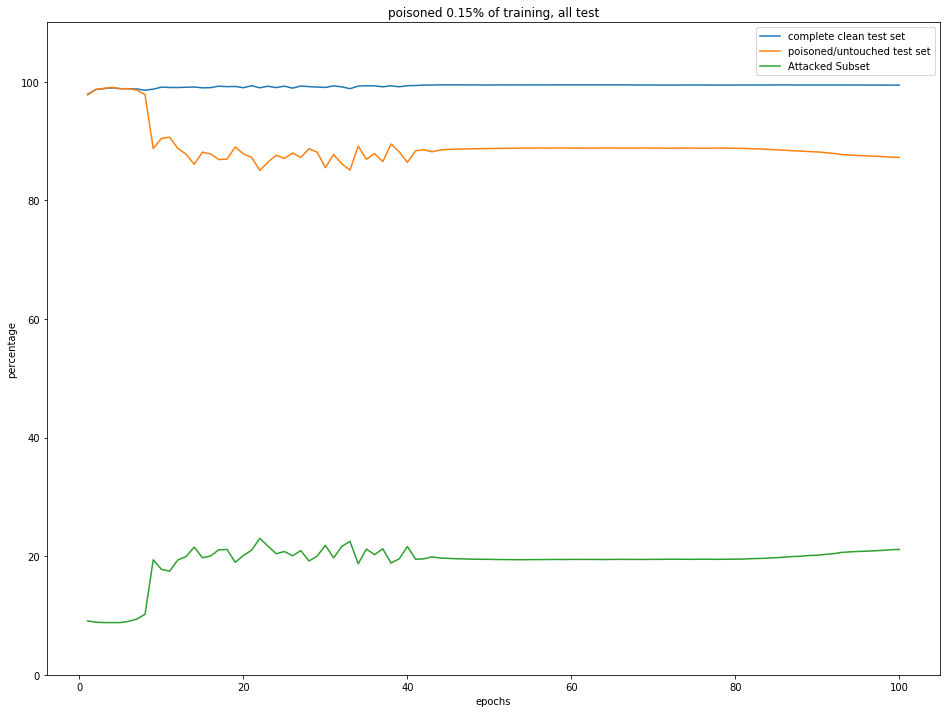

In [64]:
plot_accuracies(ret_logs)

In [56]:
def histo_calc(logs,exper=None,ind=-1):
  # if using partial test poisoning this should be later changed!
  # since everything is poisoned order is the same with clean dataset
  test_ref = test_y.argmax(axis=1)
  made = logs[exper]['poisoned_attsuccess_pred'][ind][0]
  right = logs[exper]['poisoned_attsuccess_pred'][ind][1]
  correct_pred = made == right
  correct_labels = (test_ref+1) * correct_pred
  correct_labels_ind = np.delete(np.argwhere(correct_labels != 0), correct_labels)
  correct_labels = correct_labels[correct_labels_ind]
  correct_labels = correct_labels - 1
  unique, counts = np.unique(correct_labels, return_counts=True)
  return dict(zip(unique, counts))

def top_n_attack(logs,exper=None,n=5):
  made = np.array(logs[exper]['poisoned_attsuccess_pred'])[:,0,:]
  right = np.array(logs[exper]['poisoned_attsuccess_pred'])[:,1,:]
  correct_pred = made == right
  total_correct_pred = np.sum(correct_pred,axis=1)
  #return total_correct_pred[np.argsort(total_correct_pred)[::-1][:n]
  return np.argsort(total_correct_pred)[::-1][:n]

def plot_histo(logs):
  #fig, axes = plt.subplots(nrows=4, ncols=4)
  #fig.tight_layout()
  #plt.figure(1)
  #plt.subplot(6,3,1)
  plt.ylim(0,1500)
  plt.title('last epoch poisoned 10% training, all test')
  plt.xlabel('labels')
  plt.ylabel('counts')
  exper='poisoned 10% of training, all test'
  vals = histo_calc(logs,exper=exper,ind=-1)
  plt.bar(vals.keys(),vals.values(),tick_label=range(n_classes))
  for key,val in vals.items():
    total_labels = np.count_nonzero( test_y[:,key])
    plt.text(key-0.4,val+30,'{}/{}'.format(val,total_labels))
  #plt.savefig('last epoch poisoned 10% training, all test.png')
  plt.show()
  
  top_5 = top_n_attack(logs,exper=exper,n=5)
  for i in range(len(top_5)):
    #plt.subplot(6,3,2+i)
    plt.ylim(0,1500)
    plt.title('epoch {} rank {} poisoned 10% training, all test'.format(top_5[i]+1,i+1))
    plt.xlabel('labels')
    plt.ylabel('counts')
    vals = histo_calc(logs,exper=exper,ind=top_5[i])
    plt.bar(vals.keys(),vals.values(),tick_label=range(n_classes))
    for key,val in vals.items():
      total_labels = np.count_nonzero( test_y[:,key])
      plt.text(key-0.4,val+30,'{}/{}'.format(val,total_labels))
    #plt.savefig('epoch {} rank {} poisoned 10% training, all test.png'.format(top_5[i]+1,i+1))
    plt.show()
    
  #plt.subplot(6,3,7)
  plt.ylim(0,1500)
  plt.title('last epoch poisoned 1% training, all test')
  plt.xlabel('labels')
  plt.ylabel('counts')
  exper='poisoned 1% of training, all test'
  vals = histo_calc(logs,exper=exper,ind=-1)
  plt.bar(vals.keys(),vals.values(),tick_label=range(n_classes))
  for key,val in vals.items():
    total_labels = np.count_nonzero( test_y[:,key])
    plt.text(key-0.4,val+30,'{}/{}'.format(val,total_labels))
  #plt.savefig('last epoch poisoned 1% training, all test.png')
  plt.show()
  
  top_5 = top_n_attack(logs,exper=exper,n=5)
  for i in range(len(top_5)):
    #plt.subplot(6,3,8+i)
    plt.ylim(0,1500)
    plt.title('epoch {} rank {} poisoned 1% training, all test'.format(top_5[i]+1,i+1))
    plt.xlabel('labels')
    plt.ylabel('counts')
    vals = histo_calc(logs,exper=exper,ind=top_5[i])
    plt.bar(vals.keys(),vals.values(),tick_label=range(n_classes))
    for key,val in vals.items():
      total_labels = np.count_nonzero( test_y[:,key])
      plt.text(key-0.4,val+30,'{}/{}'.format(val,total_labels))
    #plt.savefig('epoch {} rank {} poisoned 1% training, all test.png'.format(top_5[i]+1,i+1))
    plt.show()
  
  #plt.subplot(6,3,13)
  plt.ylim(0,1500)
  plt.title('last epoch poisoned 0.15% training, all test')
  plt.xlabel('labels')
  plt.ylabel('counts')
  exper='poisoned 0.15% of training, all test'
  vals = histo_calc(logs,exper=exper,ind=-1)
  plt.bar(vals.keys(),vals.values(),tick_label=range(n_classes))
  for key,val in vals.items():
    total_labels = np.count_nonzero( test_y[:,key])
    plt.text(key-0.4,val+30,'{}/{}'.format(val,total_labels))
  #plt.savefig('last epoch poisoned 0.15% training, all test.png')
  plt.show()
  
  top_5 = top_n_attack(logs,exper=exper,n=5)
  for i in range(len(top_5)):
    #plt.subplot(6,3,14+i)
    plt.ylim(0,1500)
    plt.title('epoch {} rank {} poisoned 0.15% training, all test'.format(top_5[i]+1,i+1))
    plt.xlabel('labels')
    plt.ylabel('counts')
    vals = histo_calc(logs,exper=exper,ind=top_5[i])
    plt.bar(vals.keys(),vals.values(),tick_label=range(n_classes))
    for key,val in vals.items():
      total_labels = np.count_nonzero( test_y[:,key])
      plt.text(key-0.4,val+30,'{}/{}'.format(val,total_labels))
    #plt.savefig('epoch {} rank {} poisoned 0.15% training, all test.png'.format(top_5[i]+1,i+1))
    plt.show()
  
  #plt.subplots_adjust(hspace = 0.8,wspace=0.2)
  #plt.show()

# Every two rows, has the histogram of last epoch, plus the epochs that had the highest attack success rate

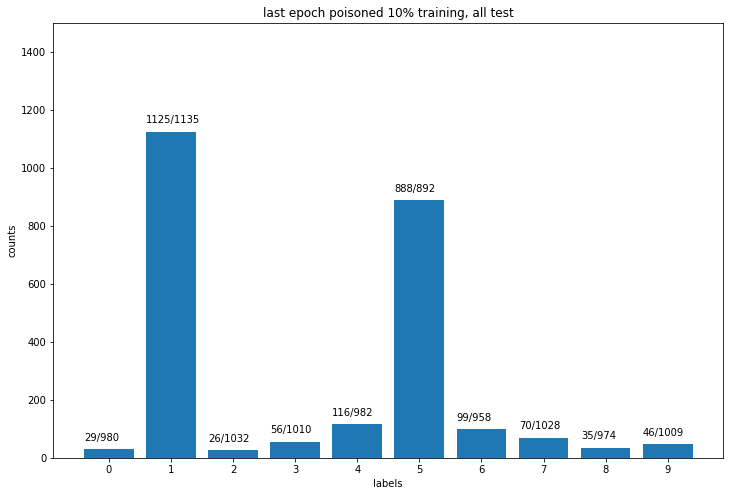

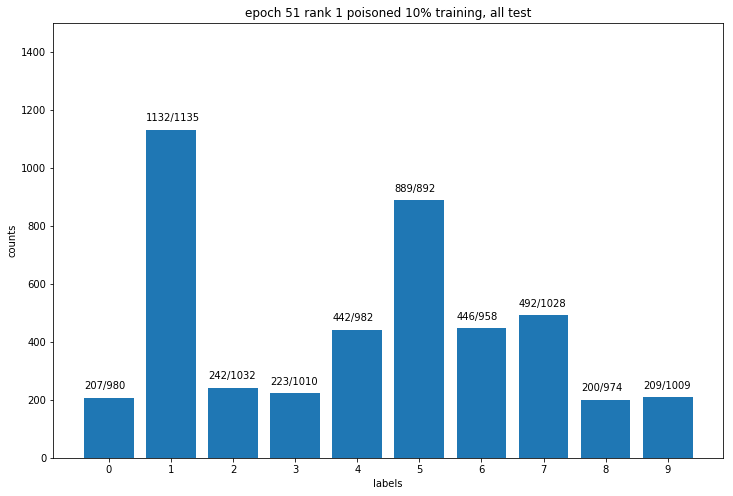

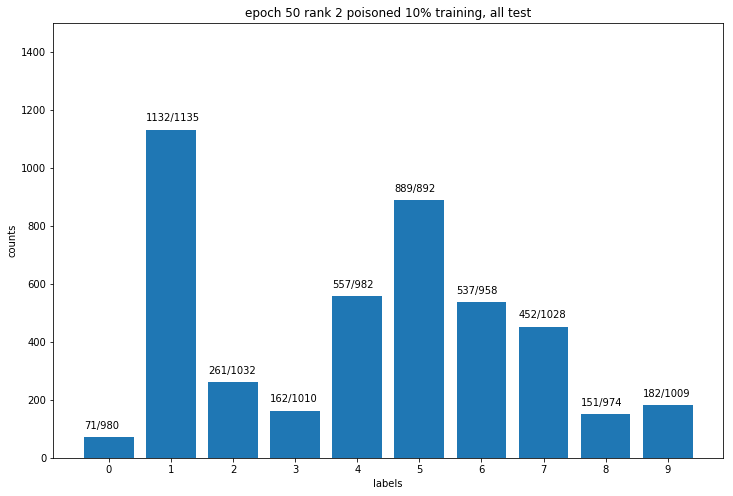

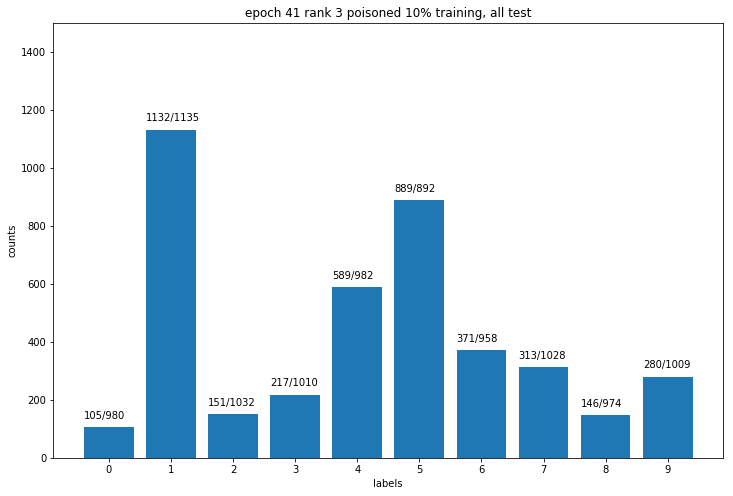

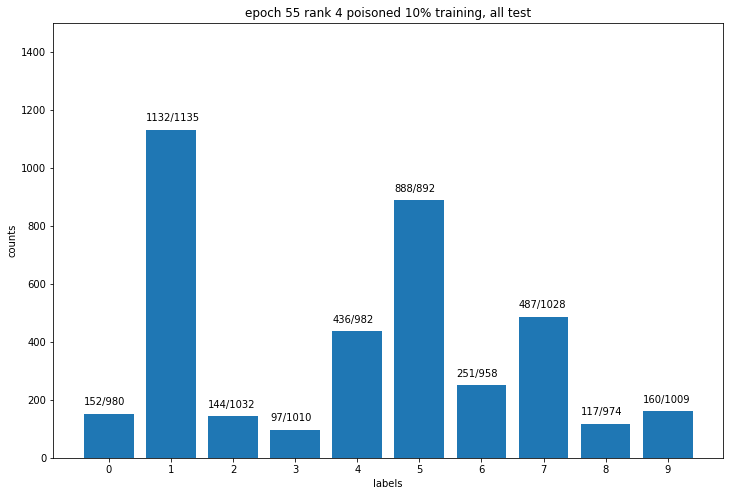

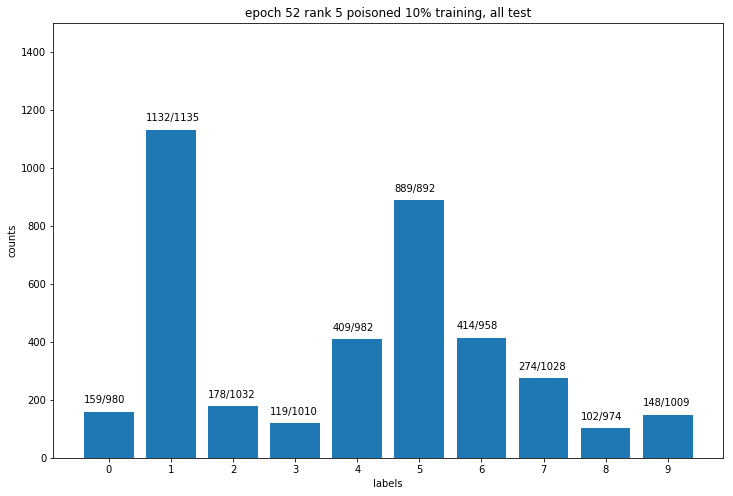

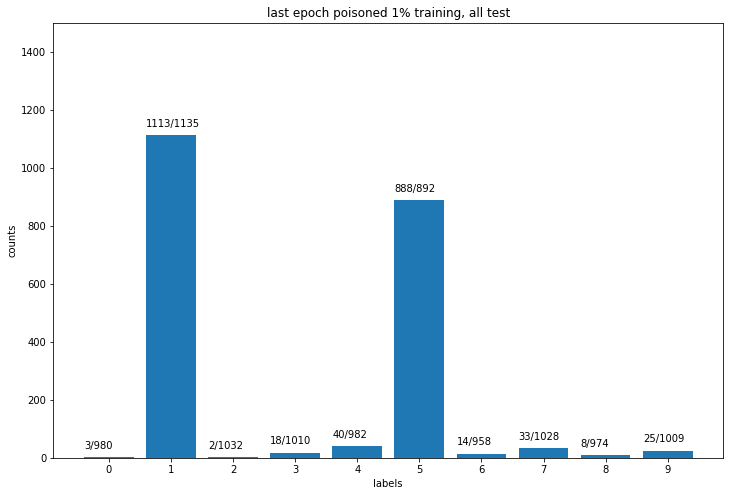

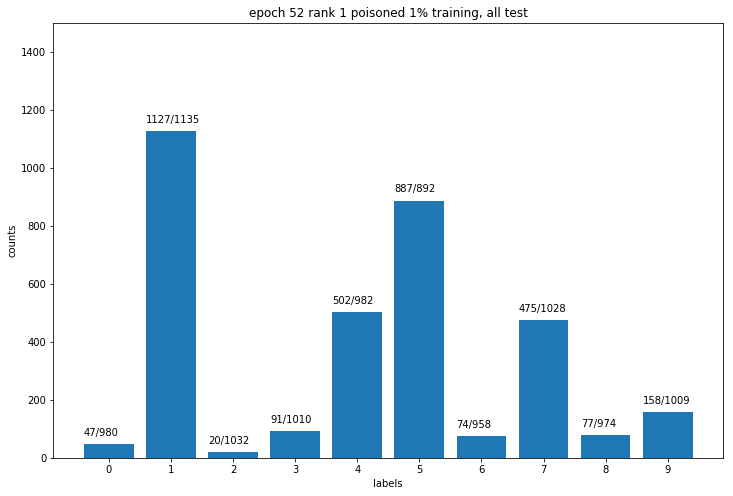

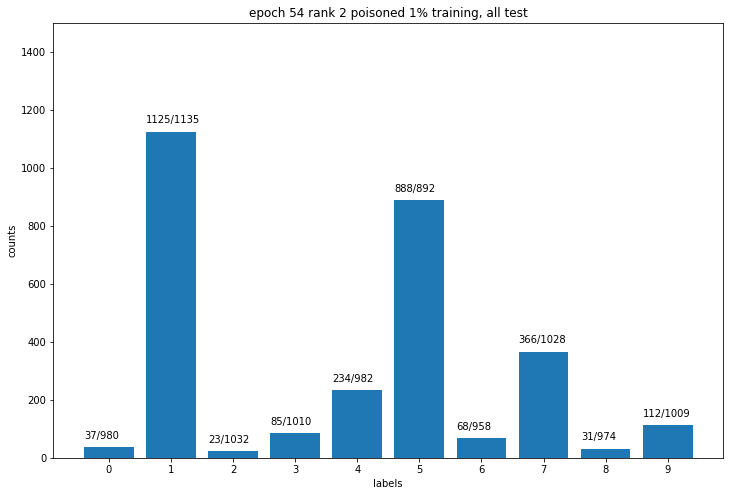

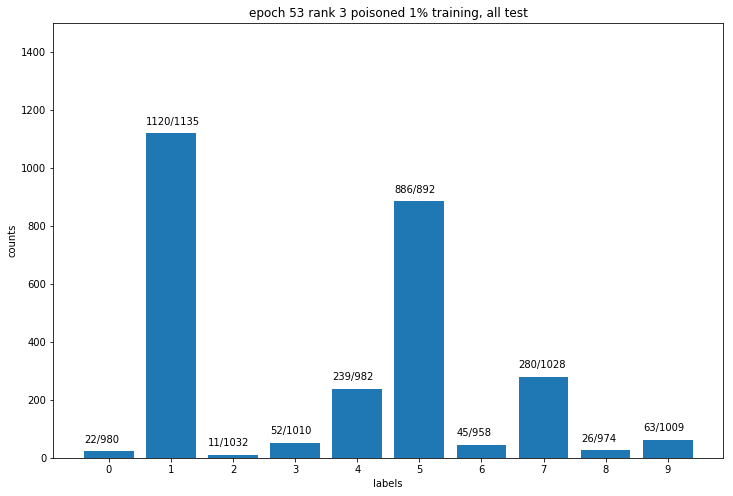

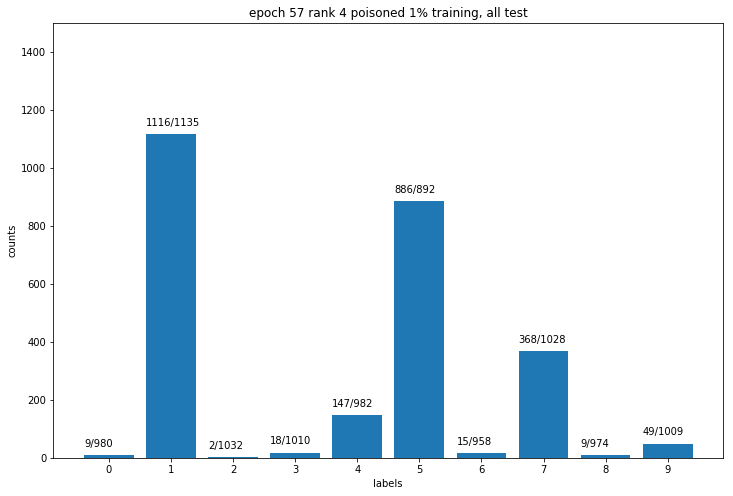

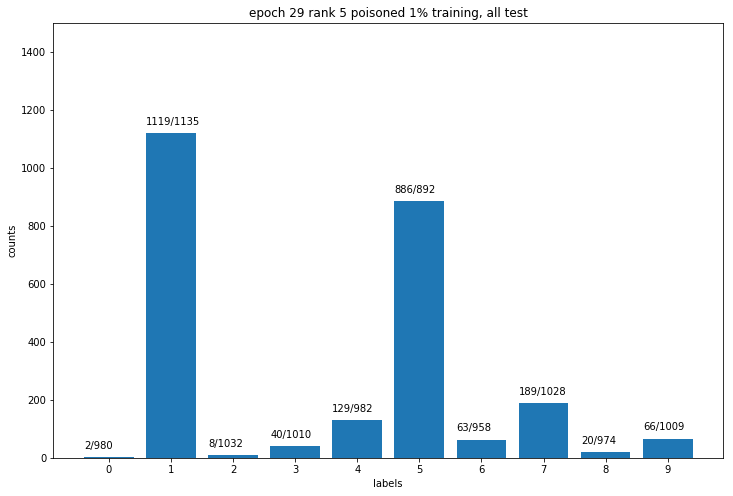

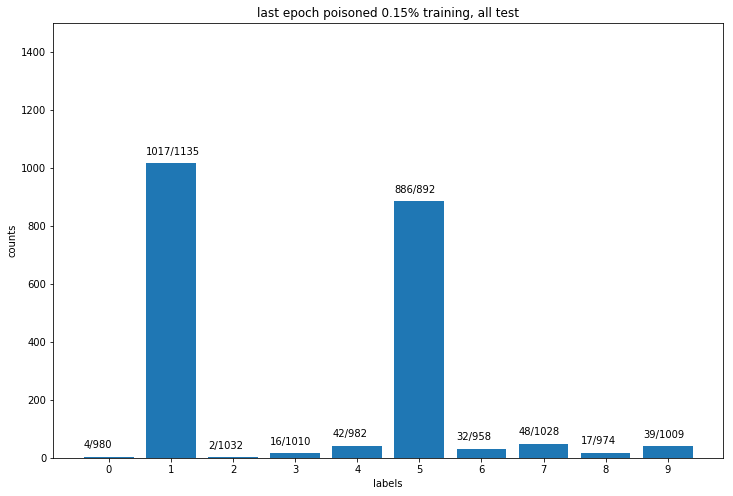

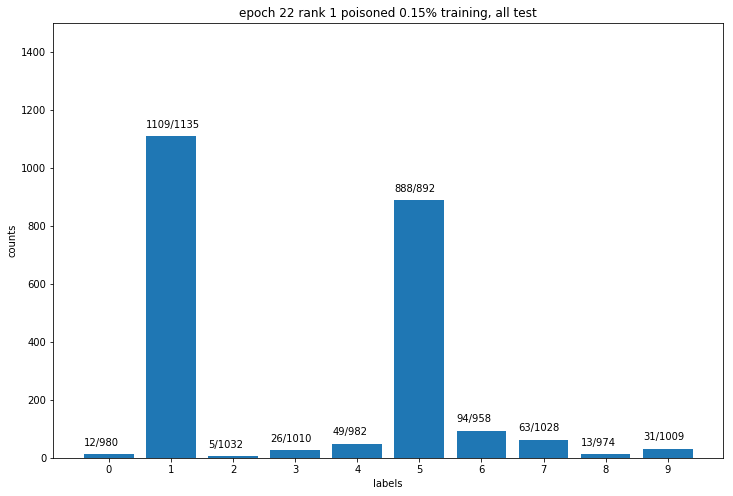

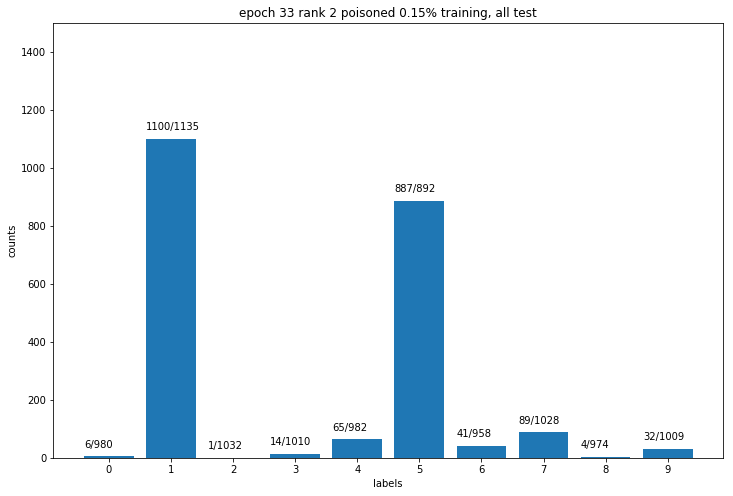

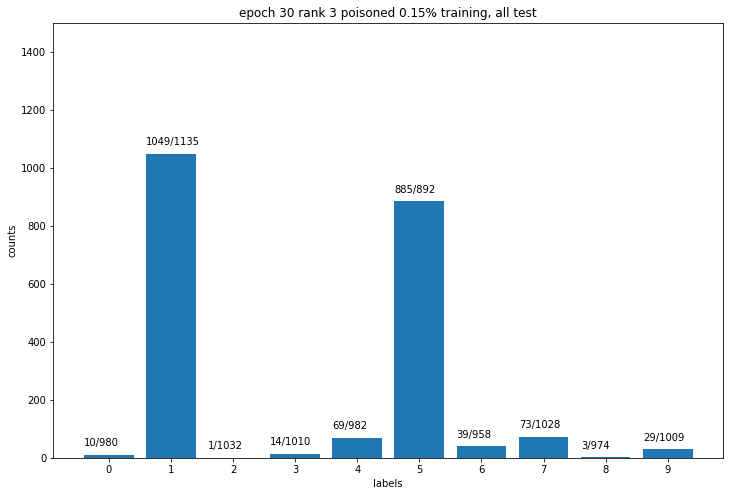

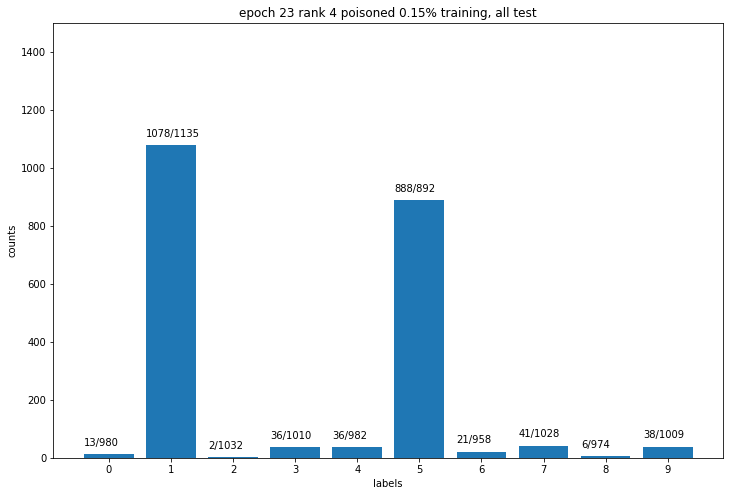

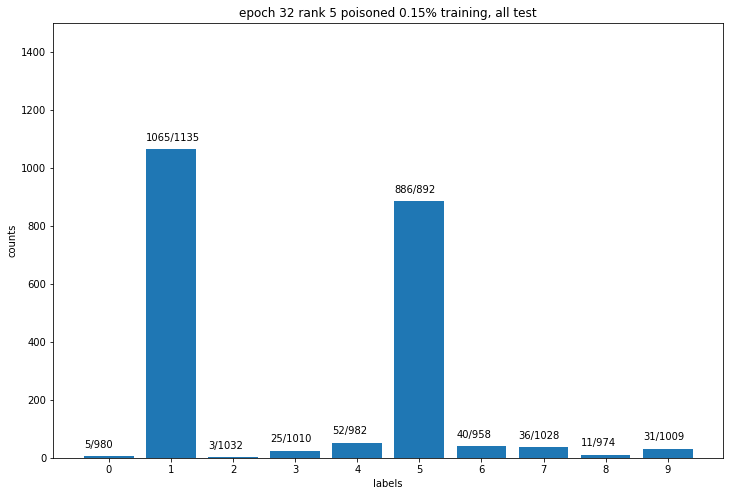

In [58]:
plot_initialize(w=12,h=8)
plot_histo(ret_logs)